# Import Modules

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.io as sci

#plotly imports
import plotly as py
import plotly.express as px
import plotly.graph_objs as go

# Load Encoded Dataset

### Encoded dataset : (# samples, 200)

In [8]:
name_array = np.load("./Encoded_vectors/encoded_vectors_name.npy")
dataset_array = np.load("./Encoded_vectors/encoded_vectors.npy").reshape(-1,200)
name_array.shape, dataset_array.shape

((22294,), (22294, 200))

# Dimension Reduction via TSNE

### Make DataFrame for Visualization (Plotly)

In [9]:
df_name = pd.DataFrame(name_array); df_name.columns = ['title']
df_dataset = pd.DataFrame(dataset_array);

tsne_3d = TSNE(n_components=3, init='pca', learning_rate='auto'); 
TSNEs_3d = pd.DataFrame(tsne_3d.fit_transform(dataset_array))
TSNEs_3d.columns = ["TSNE1_3d", "TSNE2_3d", "TSNE3_3d"]

df_plot = pd.concat([df_name, TSNEs_3d, df_dataset], axis=1, join='inner')

C:\Users\user\anaconda3\envs\cuda37\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


## Clustering by AgglomerativeClustering

![image](https://t1.daumcdn.net/cfile/tistory/994B43425AB34B7430)

#### Optional: Erase Outlier

In [17]:
outlier1 = "betamax_kick_and_reverb_02_impact.wav"
outlier2 = "HNS1 Kicks 05 - Wet.wav"

In [33]:
Erase = True

In [34]:
if Erase:
    df_plot = df_plot.drop(df_plot.index[np.argwhere([df_plot.title==outlier1])[0][1]])
    df_plot = df_plot.drop(df_plot.index[np.argwhere([df_plot.title==outlier2])[0][1]])

### Iteration Analysis

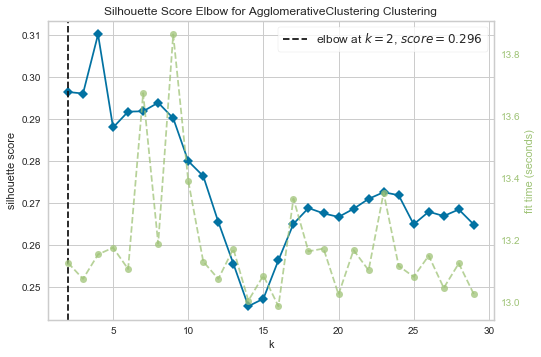

In [41]:
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()

visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings=True)
visualizer.fit(df_plot[["TSNE1_3d", "TSNE2_3d", "TSNE3_3d"]].to_numpy())
visualizer.show();

In [42]:
# Take appropriate n_cluster value, consider moderately large value n

# Clustering

In [43]:
n_clusters_ = 8

agg = AgglomerativeClustering(n_clusters_).fit(df_plot[["TSNE1_3d", "TSNE2_3d", "TSNE3_3d"]].to_numpy())
labels = agg.labels_

df_plot["Cluster"] = labels

## Make Plotly Figure and Saving

In [44]:
import datetime

In [45]:
time_tag = datetime.datetime.now().date().strftime("%m%d")

In [46]:
trace = []
for i in range(n_clusters_):
    fig = go.Scatter3d(
        x = df_plot[df_plot["Cluster"] == i]["TSNE1_3d"],
        y = df_plot[df_plot["Cluster"] == i]["TSNE2_3d"],
        z = df_plot[df_plot["Cluster"] == i]["TSNE3_3d"],
        mode = "markers",
        name = f"Cluster {i}",
        marker = {"size": 1, "color": i},
#         colorscale="Viridis",
        text = df_plot[df_plot["Cluster"] == i]["title"])
    trace.append(fig)

# layout
title = "Visualizing Clusters Using TSNE"

layout = dict(title = title,
              xaxis= dict(title= 'TSNE1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TSNE2',ticklen= 5,zeroline= False)
             )
# save
fig = go.Figure(data=trace, layout=layout)


fig.write_html(f"./results/Clustering_TSNE_3D_Agglomerative_{n_clusters_}_{time_tag}.html")

---

# Saving MAT file for GAN training

In [51]:
cgan = pd.DataFrame()
cgan_X = dataset_array
cgan_Y = np.array(labels)

In [54]:
if Erase:
    index1 = np.argwhere(name_array==outlier1).item()
    index2 = np.argwhere(name_array==outlier2).item()
    X = np.delete(cgan_X, (index1,index2), axis=0)
    Y = np.delete(cgan_Y, (index1,index2))
    print(X.shape, Y.shape)

(22292, 200) (22290,)


In [56]:
sci.savemat(f"./gan_dataset/cgan_dataset.mat",{'X':X, 'Y':Y})